# USAD

## Environment

In [272]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import torch
import torch.nn as nn
from sklearn.model_selection import train_test_split

from utils import *
from usad import *

In [273]:
!nvidia-smi -L

device = get_default_device()

GPU 0: NVIDIA GeForce RTX 3060 Ti (UUID: GPU-1e84eb32-9819-cc34-0b25-e159dc3f19e9)


## EDA - Data Pre-Processing

### Download dataset

In [302]:
file = "SCADA_Station1"
dataset = pd.read_csv(f'data/{file}_label.csv')

dataset.head(2)

,Address,IOA,Value,label
0,1143.0,11009.0,38.5,0.0
1,1143.0,11008.0,60.6,0.0


In [303]:
normal, attack = train_test_split(dataset, test_size=0.5, shuffle=False)
train_size = len(normal)

### Normal period

In [304]:
normal = normal.drop(["label"], axis=1)
normal.head(5)

,Address,IOA,Value
0,1143.0,11009.0,38.5
1,1143.0,11008.0,60.6
2,1143.0,11008.0,55.0
3,1143.0,11007.0,29.1
4,1143.0,11008.0,60.2


#### Normalization

In [305]:
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()

x = normal.values
x_scaled = min_max_scaler.fit_transform(x)
normal = pd.DataFrame(x_scaled)

In [306]:
normal.head(5)

,0,1,2
0,0.0,0.115942,0.256042
1,0.0,0.101449,0.339502
2,0.0,0.101449,0.318353
3,0.0,0.086957,0.220544
4,0.0,0.101449,0.337991


### Attack

In [307]:
attack.head(5)

,Address,IOA,Value,label
14999,1143.0,11042.0,-4.7,0.0
15000,1143.0,11042.0,4.7,0.0
15001,1143.0,11042.0,-4.7,0.0
15002,1143.0,11042.0,4.7,0.0
15003,1143.0,11042.0,-4.7,0.0


In [313]:
attack.iloc[3750 : 3772]

,Address,IOA,Value,label
18749,1143.0,11007.0,63.7,0.0
18750,1143.0,11008.0,515.5,1.0
18751,1143.0,11009.0,421.0,1.0
18752,1143.0,11043.0,-138.0,1.0
18753,1143.0,11007.0,344.0,1.0
18754,1143.0,11039.0,64.5,1.0
18755,1143.0,11009.0,448.0,1.0
18756,1143.0,11009.0,421.5,1.0
18757,1143.0,11039.0,23.5,1.0
18758,1143.0,11008.0,488.5,1.0


In [314]:
#Read data
labels = attack['label'].values
attack = attack.drop(["label"], axis=1)
attack.head(5)

,Address,IOA,Value
14999,1143.0,11042.0,-4.7
15000,1143.0,11042.0,4.7
15001,1143.0,11042.0,-4.7
15002,1143.0,11042.0,4.7
15003,1143.0,11042.0,-4.7


#### Normalization

In [315]:
from sklearn import preprocessing

x = attack.values 
x_scaled = min_max_scaler.transform(x)
attack = pd.DataFrame(x_scaled)

In [316]:
attack.head(2)

,0,1,2
0,0.0,0.594203,0.092900
1,0.0,0.594203,0.128399


### Windows

In [317]:
window_size=50

In [318]:
windows_normal=normal.values[np.arange(window_size)[None, :] + np.arange(normal.shape[0]-window_size)[:, None]]
windows_normal.shape

(14949, 50, 3)

In [319]:
windows_attack=attack.values[np.arange(window_size)[None, :] + np.arange(attack.shape[0]-window_size)[:, None]]
windows_attack.shape

(14950, 50, 3)

## Training

In [320]:
import torch.utils.data as data_utils

BATCH_SIZE =  7919
N_EPOCHS = 100
hidden_size = 100

w_size=windows_normal.shape[1]*windows_normal.shape[2]
z_size=windows_normal.shape[1]*hidden_size

windows_normal_train = windows_normal[:int(np.floor(.8 *  windows_normal.shape[0]))]
windows_normal_val = windows_normal[int(np.floor(.8 *  windows_normal.shape[0])):int(np.floor(windows_normal.shape[0]))]

train_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_train).float().view(([windows_normal_train.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

val_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_normal_val).float().view(([windows_normal_val.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

test_loader = torch.utils.data.DataLoader(data_utils.TensorDataset(
    torch.from_numpy(windows_attack).float().view(([windows_attack.shape[0],w_size]))
) , batch_size=BATCH_SIZE, shuffle=False, num_workers=0)

model = UsadModel(w_size, z_size)
model = to_device(model,device)

In [321]:
history = training(N_EPOCHS,model,train_loader,val_loader)

Epoch [0], val_loss1: 0.1338, val_loss2: 0.1382
Epoch [1], val_loss1: 0.1309, val_loss2: -0.0001
Epoch [2], val_loss1: 0.1255, val_loss2: -0.0436
Epoch [3], val_loss1: 0.1182, val_loss2: -0.0622
Epoch [4], val_loss1: 0.1092, val_loss2: -0.0695
Epoch [5], val_loss1: 0.0988, val_loss2: -0.0704
Epoch [6], val_loss1: 0.0879, val_loss2: -0.0673
Epoch [7], val_loss1: 0.0770, val_loss2: -0.0620
Epoch [8], val_loss1: 0.0672, val_loss2: -0.0559
Epoch [9], val_loss1: 0.0593, val_loss2: -0.0505
Epoch [10], val_loss1: 0.0536, val_loss2: -0.0464
Epoch [11], val_loss1: 0.0503, val_loss2: -0.0440
Epoch [12], val_loss1: 0.0474, val_loss2: -0.0419
Epoch [13], val_loss1: 0.0429, val_loss2: -0.0382
Epoch [14], val_loss1: 0.0366, val_loss2: -0.0327
Epoch [15], val_loss1: 0.0290, val_loss2: -0.0258
Epoch [16], val_loss1: 0.0218, val_loss2: -0.0193
Epoch [17], val_loss1: 0.0166, val_loss2: -0.0146
Epoch [18], val_loss1: 0.0141, val_loss2: -0.0125
Epoch [19], val_loss1: 0.0140, val_loss2: -0.0126
Epoch [20],

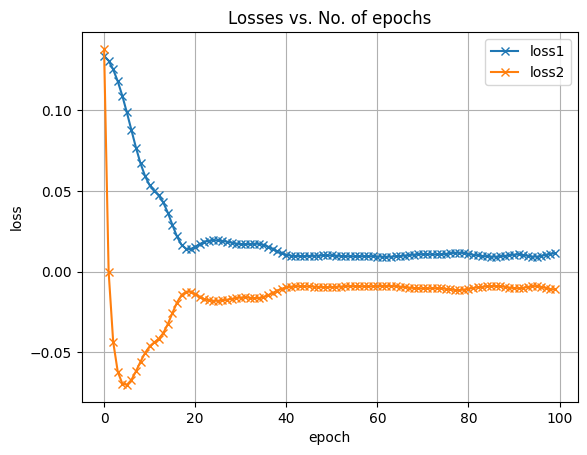

In [322]:
plot_history(history)

In [323]:
torch.save({
            'encoder': model.encoder.state_dict(),
            'decoder1': model.decoder1.state_dict(),
            'decoder2': model.decoder2.state_dict()
            }, "model.pth")

## Testing

In [324]:
checkpoint = torch.load("model.pth")

model.encoder.load_state_dict(checkpoint['encoder'])
model.decoder1.load_state_dict(checkpoint['decoder1'])
model.decoder2.load_state_dict(checkpoint['decoder2'])

<All keys matched successfully>

In [325]:
results=testing(model,test_loader)

In [326]:
windows_labels=[]
for i in range(len(labels)-window_size):
    windows_labels.append(list(np.int_(labels[i:i+window_size])))

In [327]:
y_test = [1.0 if (np.sum(window) > 0) else 0 for window in windows_labels ]

In [328]:
y_pred=np.concatenate([torch.stack(results[:-1]).flatten().detach().cpu().numpy(),
                              results[-1].flatten().detach().cpu().numpy()])

In [331]:
with open(f'scores/usad_{file}_{train_size}_{window_size}.dat', 'w') as f:
    for i in range(len(y_pred)):
        f.write(str(y_pred[i]) + ';' + str(y_test[i]) + '\n')

In [332]:
len(y_pred)

14950

In [333]:
len(y_test)

14950

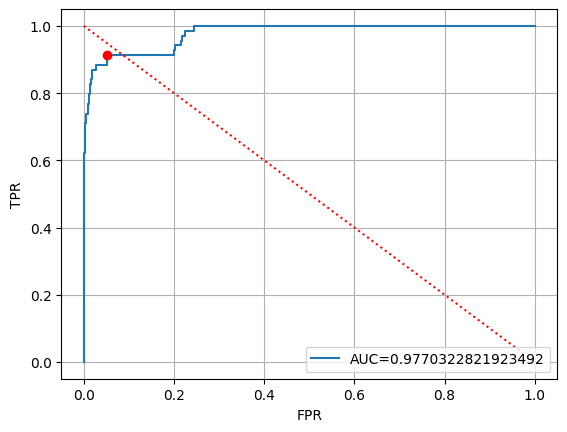

In [334]:
threshold=ROC(y_test,y_pred)

In [335]:
threshold

array([0.1139271], dtype=float32)